In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import time
import matplotlib.pyplot as plt
import triton
import triton.language as tl
import triton.testing

In [2]:
class TorchAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout = 0.1):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.num_heads = num_heads
        self.d_model = d_model
        self.head_dim = d_model // num_heads

        # Initialise Projection matrices
        self.W_q = nn.Linear(d_model, d_model, bias = False)
        self.W_k = nn.Linear(d_model, d_model, bias = False)
        self.W_v = nn.Linear(d_model, d_model, bias = False)

        # Output Projection
        self.W_o = nn.Linear(d_model, d_model, bias = False)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask = None):
        # x is of shape [batch_size, seq_len, d_model]
        batch_size, seq_len, _ = x.shape

        # Linear projections
        q = self.W_q(x) # [batch_size, seq_len, d_model]
        k = self.W_k(x) # [batch_size, seq_len, d_model]
        v = self.W_v(x) # [batch_size, seq_len, d_model]

        # Reshaping for multi-head attention
        # [batch_size, seq_len, d_model] -> [batch_size, seq_len, num_heads, head_dim]
        q = q.view(batch_size, seq_len, self.num_heads, self.head_dim)
        k = k.view(batch_size, seq_len, self.num_heads, self.head_dim)
        v = v.view(batch_size, seq_len, self.num_heads, self.head_dim)

        # [batch_size, seq_len, num_heads, head_dim] -> [batch_size, num_heads, seq_len, head_dim]
        q = q.transpose(1,2)
        k = k.transpose(1,2)
        v = v.transpose(1,2)

        # Computing attention scores
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim) # [batch_size, num_heads, seq_len, seq_len]

        # Mask for causal attention
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        # Softmax to get attention weights
        # [batch_size, num_heads, seq_len, seq_len]
        attention_weights = F.softmax(scores, dim = -1)
        # Softmax along dim = -1 to determine how much attention along each key dimension

        # Applying dropout to attention weights
        attention_weights = self.dropout(attention_weights)

        # Applying attention weights to valyues
        # [batch_size, num_heads, seq_len, head_dim]
        context = torch.matmul(attention_weights, v)

        # Concatenating heads
        # [batch_size, num_heads, seq_len, head_dim] -> [batch_size, seq_len, num_heads, head_dim]
        context = context.transpose(1, 2)
        # [batch_size, num_heads, seq_len, head_dim] -> [batch_size, seq_len, d_model]
        context = context.contiguous().view(batch_size, seq_len, self.d_model)

        # Output projection
        output = self.W_o(context)

        return output


### Creating causal mask

In [3]:
def create_causal_mask(seq_len):
    # Lower tringular matrix so that query tokens dont have access to keys that come after them in the sequence
    mask = torch.tril(torch.ones((seq_len, seq_len)))

    return mask.unsqueeze(0).unsqueeze(0) # [1, 1, seq_len, seq_len]

In [4]:
# benchmark_and_analyze()

### Naive triton implementation

In [5]:
@triton.jit
def attention_kernel(
    q_ptr, k_ptr, v_ptr, o_ptr,
    batch_size, seq_len, num_heads, head_dim,
    q_batch_stride, q_head_stride, q_seq_stride, q_head_dim_stride,
    k_batch_stride, k_head_stride, k_seq_stride, k_head_dim_stride,
    v_batch_stride, v_head_stride, v_seq_stride, v_head_dim_stride,
    o_batch_stride, o_head_stride, o_seq_stride, o_head_dim_stride,
    scale, # 1 / square_root(d_k)
    BLOCK_SIZE: tl.constexpr
    ):

    batch_idx = tl.program_id(0)
    head_idx = tl.program_id(1)
    seq_idx =  tl.program_id(2)

    # Computing pointer offsets
    # Navigate to correct starting positions
    q_batch_offset = batch_idx * q_batch_stride
    q_head_offset = head_idx * q_head_stride
    q_seq_offset = seq_idx * q_seq_stride

    # No sequence offset for K and V since each query block will see all the key blocks
    k_batch_offset = batch_idx * k_batch_stride
    k_head_offset = head_idx * k_head_stride

    v_batch_offset = batch_idx * v_batch_stride
    v_head_offset = head_idx * v_head_stride

    o_batch_offset = batch_idx * o_batch_stride
    o_head_offset = head_idx * o_head_stride
    o_seq_offset = seq_idx * o_seq_stride

    # Loading query vector for this sequence position
    q_ptrs = q_ptr + q_batch_offset + q_head_offset + q_seq_offset + tl.arange(0, BLOCK_SIZE) * q_head_dim_stride # This loads data even if it is in non contiguous locations in memory
    q = tl.load(q_ptrs, mask = tl.arange(0, BLOCK_SIZE) < head_dim, other = 0.0)

    # Initialise accumulator for weighted sum. One score for each key token
    acc = tl.zeros([BLOCK_SIZE], dtype = tl.float32)

    softmax_denominator = 0.0

    for k_seq_idx in range(seq_len):
        k_seq_offset = k_seq_idx * k_seq_stride
        k_ptrs =  k_ptr + k_batch_offset + k_head_offset + k_seq_offset + tl.arange(0, BLOCK_SIZE) * k_head_dim_stride
        k = tl.load(k_ptrs, mask = tl.arange(0, BLOCK_SIZE) < head_dim, other = 0.0)

        score = tl.sum(q * k) * scale
        attention_weight = tl.exp(score)

        softmax_denominator += attention_weight

        v_seq_offset = k_seq_idx * v_seq_stride
        v_ptrs = v_ptr + v_batch_offset + v_head_offset + v_seq_offset + tl.arange(0, BLOCK_SIZE) * v_head_dim_stride

        v = tl.load(v_ptrs, mask = tl.arange(0, BLOCK_SIZE) < head_dim, other = 0.0)

        acc += attention_weight * v

    acc /= softmax_denominator

    output_ptrs = o_ptr + o_batch_offset + o_head_offset + o_seq_offset + tl.arange(0, BLOCK_SIZE) * o_head_dim_stride
    tl.store(output_ptrs, acc, mask = tl.arange(0, BLOCK_SIZE) < head_dim)



In [6]:
class TritonAttentionNaive(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model, bias = False)
        self.W_k = nn.Linear(d_model, d_model, bias = False)
        self.W_v = nn.Linear(d_model, d_model, bias = False)

        self.W_o = nn.Linear(d_model, d_model, bias = False)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape

        q = self.W_q(x)
        k = self.W_k(x)
        v = self.W_v(x)

        q = q.view(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        k = k.view(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        v = v.view(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        o = torch.empty_like(q)

        scale = 1.0 / math.sqrt(self.head_dim)

        grid = (batch_size, self.num_heads, seq_len)

        block_size = 1
        while block_size < self.head_dim:
            block_size *= 2

        attention_kernel[grid](
            q, k, v, o,
            batch_size, seq_len, self.num_heads, self.head_dim,
            q.stride(0), q.stride(1), q.stride(2), q.stride(3),
            k.stride(0), k.stride(1), k.stride(2), k.stride(3),
            v.stride(0), v.stride(1), v.stride(2), v.stride(3),
            o.stride(0), o.stride(1), o.stride(2), o.stride(3),
            scale,
            BLOCK_SIZE = block_size
        )

        #  [batch_size, num_heads , seq_len, head_dim] -> [batch_size, seq_len, num_heads, head_dim] -> [batch_size, seq_len, d_model]
        o = o.permute(0,2,1,3).contiguous().view(batch_size, seq_len, self.d_model)
        o = self.W_o(o)

        return o

### Optimized Multi Head Attention using Triton

In [7]:
@triton.jit
def optimized_attention_kernel(
      q_ptr, k_ptr, v_ptr, o_ptr,
      batch_size, seq_len, num_heads, head_dim,
      q_batch_stride, q_head_stride, q_seq_stride, q_head_dim_stride,
      k_batch_stride, k_head_stride, k_seq_stride, k_head_dim_stride,
      v_batch_stride, v_head_stride, v_seq_stride, v_head_dim_stride,
      o_batch_stride, o_head_stride, o_seq_stride, o_head_dim_stride,
      scale, # 1 / square_root(d_k)
      BLOCK_SIZE_M: tl.constexpr, # Query Block Size
      BLOCK_SIZE_N: tl.constexpr, # Key Block Size
      BLOCK_SIZE_DMODEL : tl.constexpr, # Head Dimension Block Size,
      USE_CAUSAL_MASK : tl.constexpr
      ):

      batch_id = tl.program_id(0)
      head_id = tl.program_id(1)
      seq_start =  tl.program_id(2) * BLOCK_SIZE_M

      q_head_offset = head_id * q_head_stride
      k_head_offset = head_id * k_head_stride
      v_head_offset = head_id * v_head_stride

      q_batch_offset = batch_id * q_batch_stride
      k_batch_offset = batch_id * k_batch_stride
      v_batch_offset = batch_id * v_batch_stride

      o_head_offset = head_id * o_head_stride
      o_batch_offset = batch_id * o_batch_stride

      # Initializing accumulators
      m_i = tl.zeros([BLOCK_SIZE_M], dtype = tl.float32) - float('inf')
      l_i = tl.zeros([BLOCK_SIZE_M], dtype = tl.float32)
      acc = tl.zeros([BLOCK_SIZE_M, BLOCK_SIZE_DMODEL], dtype = tl.float32)

      q_block_mask = (seq_start + tl.arange(0, BLOCK_SIZE_M)) < seq_len

      # Processing key blocks
      for key_start in range(0, seq_len, BLOCK_SIZE_N):
          k_block_mask = (key_start + tl.arange(0, BLOCK_SIZE_N)) < seq_len

          if USE_CAUSAL_MASK:
            causal_mask = tl.arange(0, BLOCK_SIZE_M)[:, None] + seq_start >= tl.arange(0, BLOCK_SIZE_N)[None, :] + key_start # Process only tokens that occur before the given query

          # Loading Query Block [BLOCK_M, BLOCK_DMODEL]
          q_block_ptr = q_ptr + q_batch_offset + q_head_offset + (seq_start + tl.arange(0, BLOCK_SIZE_M)[:, None])* q_seq_stride + (key_start + tl.arange(0, BLOCK_SIZE_DMODEL)[None, :]) * q_head_dim_stride

          q_block = tl.load(q_block_ptr, mask=q_block_mask[:, None] & (tl.arange(0, BLOCK_SIZE_DMODEL)[None, :] < head_dim), other=0.0)

          # Loading Key Block [BLOCK_N, BLOCK_DMODEL]
          k_block_ptr = k_ptr + k_batch_offset + k_head_offset + (key_start + tl.arange(0,BLOCK_SIZE_N)[:, None])* k_seq_stride + (key_start + tl.arange(0, BLOCK_SIZE_DMODEL)[None, :]) * k_head_dim_stride

          k_block = tl.load(k_block_ptr, mask=k_block_mask[:, None] & (tl.arange(0, BLOCK_SIZE_DMODEL)[None, :] < head_dim), other=0.0)

          # Computing attention scores
          scores = tl.dot(q_block, tl.trans(k_block)) * scale

          if USE_CAUSAL_MASK:
            scores = tl.where(causal_mask, scores, float("-inf")) # This will be zeroed our during softmax

          # Stable Softmax Computation
          # 1. Computing Max for Numerical Stability
          m_ij = tl.max(scores, axis = 1)

          # 2. Updating Running Max
          m_i_new = tl.maximum(m_i, m_ij)

          # 3. Computing Exponentials with the updated max
          exp_scores = tl.exp(scores - m_i_new[:, None])

          # 4. Compute Scaling factor for previous computations
          alpha = tl.exp(m_i - m_i_new)

          # 5. Updating normalization factor
          l_i_new = alpha * l_i + tl.sum(exp_scores, axis = 1)

          # Loading Value block [BLOCK_N, BLOCK_DMODEL]
          v_block_ptr = v_ptr + v_batch_offset + v_head_offset + (key_start + tl.arange(0, BLOCK_SIZE_N)[:, None])* v_seq_stride + (key_start + tl.arange(0, BLOCK_SIZE_DMODEL)[None, :]) * v_head_dim_stride

          v_block = tl.load(v_block_ptr, mask=k_block_mask[:, None] & (tl.arange(0, BLOCK_SIZE_DMODEL)[None, :] < head_dim), other=0.0)

          acc = acc * alpha[:, None] + tl.dot(exp_scores, v_block)

          m_i = m_i_new
          l_i = l_i_new

      acc /= l_i[:, None]

      o_block_ptr = o_ptr + o_batch_offset + o_head_offset + (seq_start + tl.arange(0, BLOCK_SIZE_M)[:, None])* o_seq_stride + (tl.arange(0, BLOCK_SIZE_DMODEL)[None, :]) * o_head_dim_stride

      tl.store(o_block_ptr, acc, mask=q_block_mask[:, None] & (tl.arange(0, BLOCK_SIZE_DMODEL)[None, :] < head_dim))

In [8]:
class TritonAttentionOptimized(nn.Module):
    def __init__(self, d_model, num_heads, causal = False):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.causal = causal

        self.W_q = nn.Linear(d_model, d_model, bias = False)
        self.W_k =nn.Linear(d_model, d_model, bias = False)
        self.W_v = nn.Linear(d_model, d_model, bias = False)

        self.W_o = nn.Linear(d_model, d_model, bias = False)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape

        # Linear projections
        q = self.W_q(x)
        k = self.W_k(x)
        v = self.W_v(x)

        # Reshape for multi-head attention
        q = q.view(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        k = k.view(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        v = v.view(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        # Prepare output tensor
        output = torch.empty_like(q)

        # Scaling factor
        scale = 1.0 / math.sqrt(self.head_dim)

        BLOCK_M = 16
        BLOCK_N = 16

        # Round head_dim up to the nearest power of 2 for BLOCK_DMODEL
        BLOCK_DMODEL = 1
        while BLOCK_DMODEL < self.head_dim:
            BLOCK_DMODEL *= 2

        grid = (batch_size, self.num_heads, triton.cdiv(seq_len, BLOCK_M))

        optimized_attention_kernel[grid](
            q, k, v, output,
            batch_size, seq_len, self.num_heads, self.head_dim,
            q.stride(0), q.stride(1), q.stride(2), q.stride(3),
            k.stride(0), k.stride(1), k.stride(2), k.stride(3),
            v.stride(0), v.stride(1), v.stride(2), v.stride(3),
            output.stride(0), output.stride(1), output.stride(2), output.stride(3),
            scale,
            BLOCK_SIZE_M=BLOCK_M,
            BLOCK_SIZE_N=BLOCK_N,
            BLOCK_SIZE_DMODEL=BLOCK_DMODEL,
            USE_CAUSAL_MASK=self.causal,
        )

        output = output.permute(0, 2, 1, 3).contiguous().view(batch_size, seq_len, self.d_model)

        output = self.W_o(output)

        return output

### Flash Attention v2

Here we have hierarchial tiling, the blocks are further divided and processed as sub-blocks

In [24]:
@triton.jit
def flash_attn_v2_forward(
    # Pointers to matrices
    q_ptr, k_ptr, v_ptr, o_ptr,
    # Matrix dimensions
    batch_size, seq_len, num_heads, head_dim,
    # Strides for accessing tensors
    q_batch_stride, q_head_stride, q_seq_stride, q_head_dim_stride,
    k_batch_stride, k_head_stride, k_seq_stride, k_head_dim_stride,
    v_batch_stride, v_head_stride, v_seq_stride, v_head_dim_stride,
    o_batch_stride, o_head_stride, o_seq_stride, o_head_dim_stride,
    # Scale factor
    scale,
    BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,
    # Causal flag
    IS_CAUSAL: tl.constexpr,
):
    """
    Simplified Flash Attention V2 forward pass
    """
    # Program ID
    batch_id = tl.program_id(0)
    head_id = tl.program_id(1)
    m_id = tl.program_id(2)

    # Starting row index
    start_m = m_id * BLOCK_SIZE_M

    q_batch_offset = batch_id * q_batch_stride
    q_head_offset = head_id * q_head_stride
    k_batch_offset = batch_id * k_batch_stride
    k_head_offset = head_id * k_head_stride
    v_batch_offset = batch_id * v_batch_stride
    v_head_offset = head_id * v_head_stride
    o_batch_offset = batch_id * o_batch_stride
    o_head_offset = head_id * o_head_stride

    # Initialize accumulators
    m_i = tl.zeros([BLOCK_SIZE_M], dtype=tl.float32) - float("inf")
    l_i = tl.zeros([BLOCK_SIZE_M], dtype=tl.float32)
    acc = tl.zeros([BLOCK_SIZE_M, BLOCK_SIZE_K], dtype=tl.float32)

    # Create row indices and mask
    row_indices = start_m + tl.arange(0, BLOCK_SIZE_M)
    row_mask = row_indices < seq_len

    # Loading Q block once - I'll reuse it for all K,V blocks
    q_block = tl.load(
        q_ptr + q_batch_offset + q_head_offset +
        row_indices[:, None] * q_seq_stride +
        tl.arange(0, BLOCK_SIZE_K)[None, :] * q_head_dim_stride,
        mask=row_mask[:, None] & (tl.arange(0, BLOCK_SIZE_K)[None, :] < head_dim),
        other=0.0
    )

    # Process blocks of K and V
    for start_n in range(0, seq_len, BLOCK_SIZE_N):
        col_indices = start_n + tl.arange(0, BLOCK_SIZE_N)
        col_mask = col_indices < seq_len

        if IS_CAUSAL:
            causal_mask = row_indices[:, None] >= col_indices[None, :]

        # Loading K block
        k_block = tl.load(
            k_ptr + k_batch_offset + k_head_offset +
            col_indices[:, None] * k_seq_stride +
            tl.arange(0, BLOCK_SIZE_K)[None, :] * k_head_dim_stride,
            mask=col_mask[:, None] & (tl.arange(0, BLOCK_SIZE_K)[None, :] < head_dim),
            other=0.0
        )

        scores = tl.dot(q_block, tl.trans(k_block)) * scale

        if IS_CAUSAL:
            scores = tl.where(causal_mask, scores, float('-inf'))

        # Compute new max for stable softmax
        m_i_new = tl.maximum(m_i, tl.max(scores, axis=1))
        alpha = tl.exp(m_i - m_i_new)

        # Update max values
        m_i = m_i_new

        # Compute softmax values with updated max
        p = tl.exp(scores - m_i[:, None])

        # Load V block
        v_block = tl.load(
            v_ptr + v_batch_offset + v_head_offset +
            col_indices[:, None] * v_seq_stride +
            tl.arange(0, BLOCK_SIZE_K)[None, :] * v_head_dim_stride,
            mask=col_mask[:, None] & (tl.arange(0, BLOCK_SIZE_K)[None, :] < head_dim),
            other=0.0
        )

        # Update sum of exponentials
        l_i_new = alpha * l_i + tl.sum(p, axis=1)

        # Update weighted sum
        acc_new = alpha[:, None] * acc + tl.dot(p, v_block)

        # Update accumulators
        l_i = l_i_new
        acc = acc_new

    # Normalize output
    out = acc / l_i[:, None]

    # Store output
    tl.store(
        o_ptr + o_batch_offset + o_head_offset +
        row_indices[:, None] * o_seq_stride +
        tl.arange(0, BLOCK_SIZE_K)[None, :] * o_head_dim_stride,
        out,
        mask=row_mask[:, None] & (tl.arange(0, BLOCK_SIZE_K)[None, :] < head_dim)
    )

In [25]:
class FlashAttentionV2(torch.nn.Module):
    def __init__(
        self,
        d_model,
        num_heads,
        dropout=0.0,
        causal=False,
        block_size=64
    ):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.dropout = dropout
        self.causal = causal
        self.block_size = block_size

        # Linear projections
        self.W_q = torch.nn.Linear(d_model, d_model, bias=False)
        self.W_k = torch.nn.Linear(d_model, d_model, bias=False)
        self.W_v = torch.nn.Linear(d_model, d_model, bias=False)
        self.W_o = torch.nn.Linear(d_model, d_model, bias=False)

        # Make sure head_dim is a power of 2
        if not (self.head_dim & (self.head_dim - 1) == 0):
            raise ValueError(f"Head dimension ({self.head_dim}) must be a power of 2")

    def forward(self, x):
        batch_size, seq_len, _ = x.shape

        # Linear projections
        q = self.W_q(x)
        k = self.W_k(x)
        v = self.W_v(x)

        # Reshape for multi-head attention
        q = q.view(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        k = k.view(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        v = v.view(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        # Prepare output tensor
        output = torch.empty_like(q)

        # Scaling factor
        scale = 1.0 / math.sqrt(self.head_dim)

        # Calculate grid dimensions
        grid = (
            batch_size,
            self.num_heads,
            triton.cdiv(seq_len, self.block_size)
        )

        # Round head_dim up to the nearest power of 2 if needed
        block_k = self.head_dim
        if block_k & (block_k - 1) != 0:
            block_k = 1
            while block_k < self.head_dim:
                block_k *= 2

        # Launch kernel
        flash_attn_v2_forward[grid](
            q, k, v, output,
            batch_size, seq_len, self.num_heads, self.head_dim,
            q.stride(0), q.stride(1), q.stride(2), q.stride(3),
            k.stride(0), k.stride(1), k.stride(2), k.stride(3),
            v.stride(0), v.stride(1), v.stride(2), v.stride(3),
            output.stride(0), output.stride(1), output.stride(2), output.stride(3),
            scale,
            BLOCK_SIZE_M=self.block_size,
            BLOCK_SIZE_N=self.block_size,
            BLOCK_SIZE_K=block_k,
            IS_CAUSAL=self.causal,
        )

        # Reshape output back
        output = output.permute(0, 2, 1, 3).contiguous().view(batch_size, seq_len, self.d_model)

        # Apply dropout
        if self.dropout > 0.0 and self.training:
            output = torch.nn.functional.dropout(output, p=self.dropout)

        # Final linear projection
        output = self.W_o(output)

        return output

In [26]:
# !pip install flash-attn

In [27]:
try:
    from flash_attn import flash_attn_func
    FLASH_ATTN_AVAILABLE = True
except ImportError:
    print("flash-attn library not found. Will skip that implementation.")
    FLASH_ATTN_AVAILABLE = False

In [28]:
# Define constants
DEVICE = torch.device('cuda')
D_MODEL = 768
NUM_HEADS = 12
BATCH_SIZE = 1

# flash-attn library typically uses these block sizes
FLASH_BLOCK_SIZE = 64
FLASH_SUB_BLOCK_SIZE = 16

In [29]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['seq_len'],
        x_vals=[2**i for i in range(8, 13)],  # 256 to 4096
        x_log=True,
        line_arg='provider',
        line_vals=['torch', 'triton_naive', 'triton_optimized', 'flash_v2', 'flash_attn_lib'],
        # line_vals=['torch', 'triton_naive', 'triton_optimized', 'flash_v2'],
        line_names=['PyTorch', 'Triton Naive', 'Triton Optimized', 'My Flash V2', 'Flash-Attn Lib'],
        # line_names=['PyTorch', 'Triton Naive', 'Triton Optimized', 'My Flash V2'],
        styles=[('blue', '-'), ('green', '-'), ('red', '-'), ('purple', '-'), ('orange', '-')],
        # styles=[('blue', '-'), ('green', '-'), ('red', '-'), ('purple', '-')],
        # ylabel='Latency (ms)',
        plot_name='attention-performance',
        args={'d_model': D_MODEL, 'num_heads': NUM_HEADS, 'batch_size': BATCH_SIZE},
    )
)
def benchmark_attention(seq_len, provider, d_model, num_heads, batch_size):
    """Benchmark different attention implementations."""
    x = torch.randn((batch_size, seq_len, d_model), device=DEVICE)

    # Create the appropriate model based on provider
    if provider == 'torch':
        model = TorchAttention(d_model, num_heads).to(DEVICE)
        run_func = lambda: model(x)

    elif provider == 'triton_naive':
        model = TritonAttentionNaive(d_model, num_heads).to(DEVICE)
        run_func = lambda: model(x)

    elif provider == 'triton_optimized':
        model = TritonAttentionOptimized(d_model, num_heads, causal=False).to(DEVICE)
        run_func = lambda: model(x)

    elif provider == 'flash_v2':
        model = FlashAttentionV2(
            d_model,
            num_heads,
            block_size=FLASH_BLOCK_SIZE
        ).to(DEVICE)
        run_func = lambda: model(x)

    elif provider == 'flash_attn_lib':
        if not FLASH_ATTN_AVAILABLE:
            return float('inf'), float('inf'), float('inf')

        # For the flash-attn library, prepare inputs differently
        q_proj = torch.nn.Linear(d_model, d_model, bias=False).to(DEVICE)
        k_proj = torch.nn.Linear(d_model, d_model, bias=False).to(DEVICE)
        v_proj = torch.nn.Linear(d_model, d_model, bias=False).to(DEVICE)

        q = q_proj(x).view(batch_size, seq_len, num_heads, d_model // num_heads)
        k = k_proj(x).view(batch_size, seq_len, num_heads, d_model // num_heads)
        v = v_proj(x).view(batch_size, seq_len, num_heads, d_model // num_heads)

        q = q.to(torch.float16)
        k = k.to(torch.float16)
        v = v.to(torch.float16)

        run_func = lambda: flash_attn_func(q, k, v, causal=False)

    else:
        raise ValueError(f"Unknown provider: {provider}")

    # Warmup
    for _ in range(3):
        _ = run_func()
    torch.cuda.synchronize()

    # Benchmark
    quantiles = [0.5, 0.2, 0.8]
    ms, min_ms, max_ms = triton.testing.do_bench(run_func, quantiles=quantiles)

    return ms, max_ms, min_ms

attention-performance:
   seq_len    PyTorch  Triton Naive  Triton Optimized  My Flash V2  Flash-Attn Lib
0    256.0   0.267264      1.033728          0.223232     0.201728        0.024576
1    512.0   0.580576      3.821568          0.395776     0.314368        0.047104
2   1024.0   2.371584     14.738944          0.983552     0.666624        0.090112
3   2048.0   8.394753     58.597378          3.210240     1.766912        0.259584
4   4096.0  31.447041    231.646210         10.640385     4.966400        0.864256


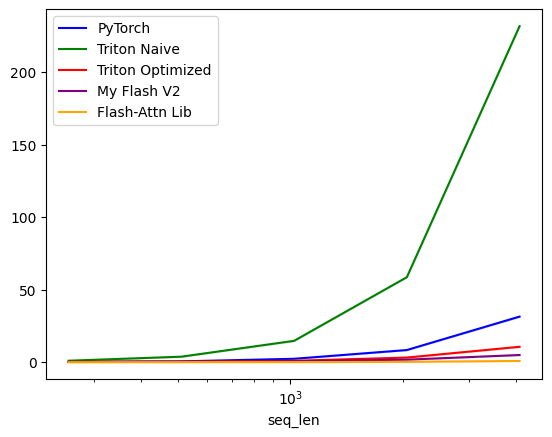

In [30]:
benchmark_attention.run(save_path='./attention_benchmark', print_data=True)